In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from dln_dA import dA
import numpy as np
from matplotlib import pyplot as plt
import theano
import theano.tensor as T
from theano.tensor.shared_randomstreams import RandomStreams
import timeit

In [3]:
# def make_simple_data(w, h, aw, ah):
#     values = np.random.uniform(0.0, 1.0, (ah, aw))
#     result = np.zeros((w, h, 3))
#     for i in range(ah):
#         for j in range(aw):
#             result[i*(h/ah):(i+1)*(h/ah), 
#                    j*(w/aw):(j+1)*(w/aw)] = values[i, j]
#     return result

# def make_simple_dataset(w, h, aw, ah, n):
#     return np.asarray([make_simple_data(w, h, aw, ah) for i in range(n)], dtype=theano.config.floatX)

import scipy.misc
def load_training_img(index):
    return scipy.misc.imread('../../TrainingData/LabeledData/capture' + str(index).zfill(6) + '.png')[:,:,:-1]

def load_images(lower, upper):
    return np.asarray([load_training_img(i) for i in range(lower, upper)])

def normalize_and_flatten(imgs):
    return (imgs / 255.0).reshape(imgs.shape[0], imgs.shape[1]*imgs.shape[2]*imgs.shape[3])

# print normalize_and_flatten(load_images(1,3))

In [4]:
tr_ex_start_index = 0
n_training_examples = 1000

training_data = normalize_and_flatten(load_images(tr_ex_start_index, tr_ex_start_index+n_training_examples))

trainig_data = np.asarray(training_data, dtype=theano.config.floatX)
train_set_x = theano.shared(training_data, name='train', borrow=True)

In [46]:
learning_rate = 4
batch_size = 10
training_epochs = 300
n_train_batches = n_training_examples/batch_size

h=64
w=64
colors=3
hidden_units=100

In [6]:
# allocate symbolic variables for the data
index = T.lscalar()    # index to a [mini]batch
x = T.matrix('x')  # the data is presented as rasterized images

rng = np.random.RandomState(123)
theano_rng = RandomStreams(rng.randint(2 ** 30))

da = dA(
    numpy_rng=rng,
    theano_rng=theano_rng,
    input=x,
    n_visible=h*w*colors,
    n_hidden=hidden_units
)

cost, updates = da.get_cost_updates(
    corruption_level=0.0,
    learning_rate=learning_rate
)

train_da = theano.function(
    [index],
    cost,
    updates=updates,
    givens={
        x: train_set_x[index * batch_size: (index + 1) * batch_size]
    }
)


In [91]:
start_time = timeit.default_timer()

############
# TRAINING #
############

# go through training epochs
for epoch in xrange(training_epochs):
    # go through training set
    c = []
    for batch_index in xrange(n_train_batches):
        c.append(train_da(batch_index))

    if epoch == 0 or (epoch+1) % 10 == 0:
        print 'Training epoch %d, cost ' % epoch, np.mean(c)

end_time = timeit.default_timer()

training_time = (end_time - start_time)

print 'The code ran for %.2fm' % (training_time / 60.)

Training epoch 0, cost  0.00580496535713
Training epoch 9, cost  0.00580208518914
Training epoch 19, cost  0.00579420044858
Training epoch 29, cost  0.00577410295532
Training epoch 39, cost  0.0057616394998
Training epoch 49, cost  0.00573528398339
Training epoch 59, cost  0.00573588790145
Training epoch 69, cost  0.00572539230375
Training epoch 79, cost  0.00568565454769
Training epoch 89, cost  0.00568121562252
Training epoch 99, cost  0.00562793541741
Training epoch 109, cost  0.00558707103848
Training epoch 119, cost  0.00559576318469
Training epoch 129, cost  0.00560672402691
Training epoch 139, cost  0.00550936253278
Training epoch 149, cost  0.00554992898537
Training epoch 159, cost  0.00554574789984
Training epoch 169, cost  0.00548061188302
Training epoch 179, cost  0.00554178336685
Training epoch 189, cost  0.00553559081169
Training epoch 199, cost  0.00550545048647
Training epoch 209, cost  0.00551075365474
Training epoch 219, cost  0.00549195258255
Training epoch 229, cost 

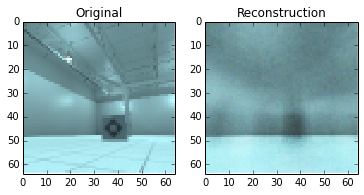

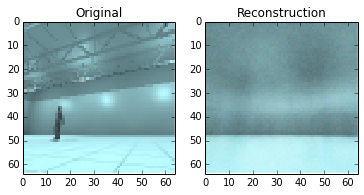

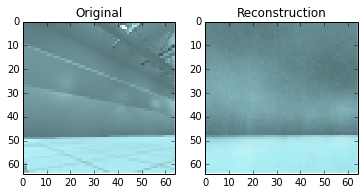

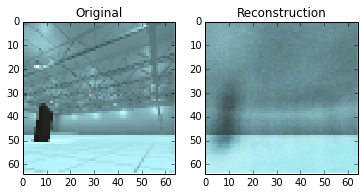

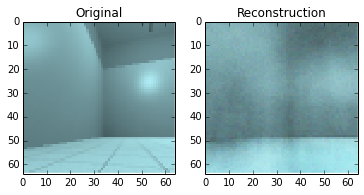

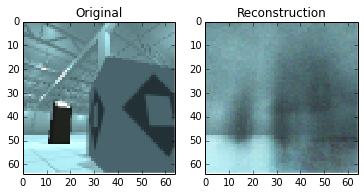

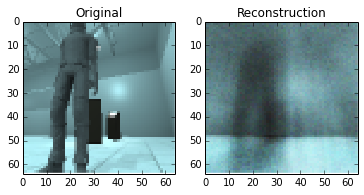

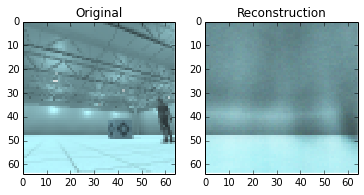

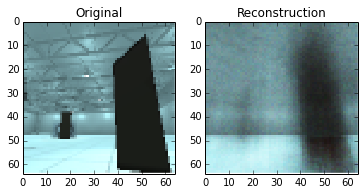

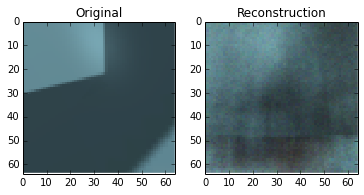

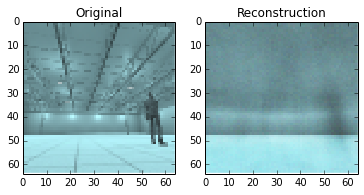

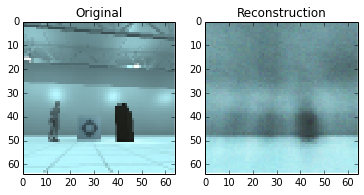

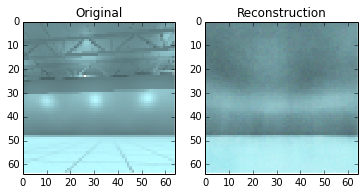

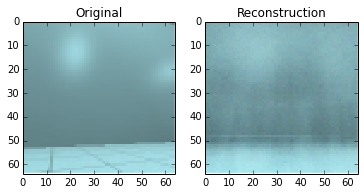

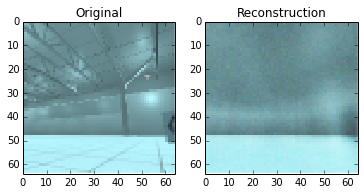

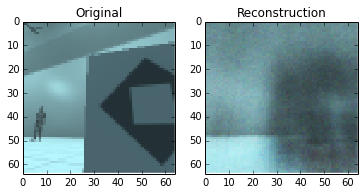

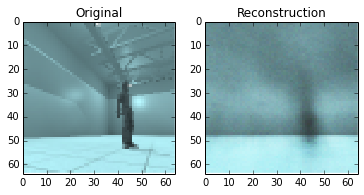

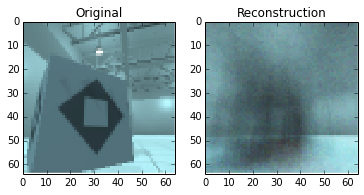

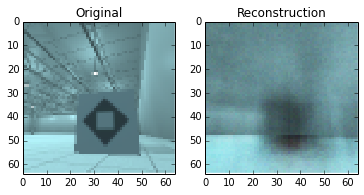

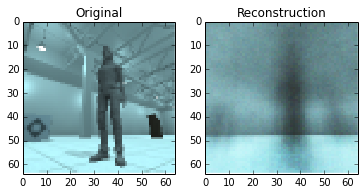

In [98]:
def make_rgb_from_val(data, w, h):
    return np.repeat(batch[index].reshape(h, w), 3).reshape(h, w, 3)

def forceAspect(ax,aspect=1):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)


def save_images(data1, data2, filename, title1='Original', title2='Reconstruction'):    
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_title(title1)
    ax1.set_ylim(64,0)
    ax1.set_xlim(0,64)
    
    ax2.set_title(title2)
    ax2.set_ylim(64,0)
    ax2.set_xlim(0,64)
    
    ax1.imshow(data1, interpolation='nearest')
    ax2.imshow(data2, interpolation='nearest')
    
    plt.savefig(filename)
    
    
test_start_index = tr_ex_start_index+n_training_examples
n_test_examples = 20
test_data = normalize_and_flatten(load_images(test_start_index, test_start_index+n_test_examples))
test_data = np.asarray(test_data, dtype=theano.config.floatX)
    
n_batches_plot = 2
for i in range(n_batches_plot):
    for j in range(batch_size):
        batch = test_data[i*batch_size: (i+1)*batch_size]
        example_img = batch[j].reshape(h, w, colors)
        enc = da.get_reconstructed_input(da.get_hidden_values(da.x))
        reconstr_batch = enc.eval({da.x: batch})
        example_recon = reconstr_batch[j].reshape(h, w, colors)
        save_images(example_img, example_recon, 'results/exp02/test-recon_' + str(batch_size*i + j).zfill(6) + '.png')



In [94]:
test_start = 2000
n_test_examples = 20
test_data = normalize_and_flatten(load_images(test_start, test_start+n_test_examples))
test_data = np.asarray(test_data, dtype=theano.config.floatX)